<div style='background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); padding: 40px; border-radius: 15px; box-shadow: 0 10px 30px rgba(0,0,0,0.3);'>
    <h1 style='color: white; text-align: center; font-size: 48px; margin: 0; font-weight: 800; text-shadow: 2px 2px 4px rgba(0,0,0,0.3);'>MODÉLISATION</h1>
    <h2 style='color: #e0e7ff; text-align: center; font-size: 28px; margin-top: 15px; font-weight: 300;'>Papa Magatte Diop - Logistic Regression & LightGBM</h2>
    <p style='color: white; text-align: center; font-size: 16px; margin-top: 20px; opacity: 0.9;'>Projet CLF02 - Prêt à dépenser | Phase 4</p>
</div>

**Modeles assignes:**
1. Logistic Regression
2. LightGBM

**Processus pour chaque modele:**
- **Baseline**: Parametres par defaut -> Metriques Train + Test
- **Finetuning**: Optimisation hyperparametres -> Metriques Test uniquement

<div class='section-header'>
    <h2 style='margin: 0;'>1. CONFIGURATION & SETUP</h2>
</div>

In [17]:
# Imports standards
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import joblib
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
    classification_report, f1_score, precision_score, recall_score,
    ConfusionMatrixDisplay
)

# LightGBM
import lightgbm as lgb

# MLflow
import mlflow
import mlflow.sklearn
import mlflow.lightgbm

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Configuration personnalisée
TEAM_MEMBER = "papa"
RANDOM_STATE = 42
N_FOLDS = 5

print("✓ Imports réussis")
print(f"✓ Configuration: {TEAM_MEMBER.upper()}")
print(f"✓ Modèles: Logistic Regression + LightGBM")

✓ Imports réussis
✓ Configuration: PAPA
✓ Modèles: Logistic Regression + LightGBM


In [18]:
# Configuration MLflow
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment(f"credit_scoring_{TEAM_MEMBER}")

print(f"✓ MLflow configuré")
print(f"  Experiment: credit_scoring_{TEAM_MEMBER}")
print(f"  Tracking URI: {mlflow.get_tracking_uri()}")

✓ MLflow configuré
  Experiment: credit_scoring_papa
  Tracking URI: file:../mlruns


<div class='section-header'>
    <h2 style='margin: 0;'>2. CHARGEMENT DES DONNÉES</h2>
</div>

In [25]:
# Charger les données avec features sélectionnées (Étape 0)
DATA_PATH = Path('../data/processed')

print("Chargement des données avec features sélectionnées...")
train = pd.read_csv(DATA_PATH / 'train_final.csv')
test = pd.read_csv(DATA_PATH / 'test_final.csv')

print(f"✓ Train: {train.shape}")
print(f"✓ Test: {test.shape}")
print(f"\nMémoire utilisée: {train.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Chargement des données avec features sélectionnées...
✓ Train: (307511, 241)
✓ Test: (48744, 240)

Mémoire utilisée: 578.91 MB


In [26]:
# Séparation X et y
X = train.drop('TARGET', axis=1)
y = train['TARGET']
X_test = test.copy()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nDistribution TARGET:")
print(f"  Classe 0 (remboursé): {(y==0).sum():,} ({(y==0).sum()/len(y)*100:.2f}%)")
print(f"  Classe 1 (défaut): {(y==1).sum():,} ({(y==1).sum()/len(y)*100:.2f}%)")
print(f"  Ratio déséquilibre: {(y==0).sum() / (y==1).sum():.2f}:1")

X shape: (307511, 240)
y shape: (307511,)

Distribution TARGET:
  Classe 0 (remboursé): 282,686 (91.93%)
  Classe 1 (défaut): 24,825 (8.07%)
  Ratio déséquilibre: 11.39:1


In [27]:
# Split train/validation (80/20) avec stratification
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

print("Split train/validation:")
print(f"  X_train: {X_train.shape}")
print(f"  X_val: {X_val.shape}")
print(f"  y_train: Classe 1 = {(y_train==1).sum()/len(y_train)*100:.2f}%")
print(f"  y_val: Classe 1 = {(y_val==1).sum()/len(y_val)*100:.2f}%")
print(f"\n✓ Stratification réussie!")

Split train/validation:
  X_train: (246008, 240)
  X_val: (61503, 240)
  y_train: Classe 1 = 8.07%
  y_val: Classe 1 = 8.07%

✓ Stratification réussie!


<div class='section-header'>
    <h2 style='margin: 0;'>3. FONCTIONS D'ÉVALUATION</h2>
</div>

In [28]:
def calculate_business_cost(y_true, y_pred, threshold=0.5):
    """
    Calcule le coût métier.
    
    Hypothèses:
    - FN (refuser bon client): coût d'opportunité = -1
    - FP (accepter mauvais client): perte moyenne = -10
    - TP (accepter bon client): gain = +1
    - TN (refuser mauvais client): gain = 0
    """
    y_pred_binary = (y_pred >= threshold).astype(int)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_binary).ravel()
    
    # Coûts
    cost_fn = -1  # Refuser bon client (coût opportunité)
    cost_fp = -10  # Accepter mauvais client (perte)
    gain_tp = 1   # Accepter bon client (gain)
    gain_tn = 0   # Refuser mauvais client (pas de gain/perte)
    
    total_cost = (fn * cost_fn) + (fp * cost_fp) + (tp * gain_tp) + (tn * gain_tn)
    
    return total_cost, {'TP': tp, 'TN': tn, 'FP': fp, 'FN': fn}


def evaluate_model(y_true, y_pred_proba, threshold=0.5):
    """Évalue un modèle avec toutes les métriques."""
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Métriques standards
    auc = roc_auc_score(y_true, y_pred_proba)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    # Coût métier
    business_cost, cm_dict = calculate_business_cost(y_true, y_pred_proba, threshold)
    
    return {
        'auc': auc,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'business_cost': business_cost,
        'threshold': threshold,
        **cm_dict
    }

print("✓ Fonctions d'évaluation définies")

✓ Fonctions d'évaluation définies


<div class='section-header'>
    <h2 style='margin: 0;'>4. MODÈLE 1 : LOGISTIC REGRESSION</h2>
</div>

In [30]:
# Après le split train/validation, ajoute cette cellule :

# Identifier et supprimer les colonnes non-numériques
print("Vérification des types de données...")
print(X_train.dtypes.value_counts())

# Sélectionner uniquement les colonnes numériques
numeric_cols = X_train.select_dtypes(include=[np.number]).columns
print(f"\nColonnes numériques: {len(numeric_cols)}/{len(X_train.columns)}")

# Filtrer
X_train = X_train[numeric_cols]
X_val = X_val[numeric_cols]

print(f"\n✓ Données filtrées : {X_train.shape}")

Vérification des types de données...
float64    178
int64       61
object       1
Name: count, dtype: int64

Colonnes numériques: 239/240

✓ Données filtrées : (246008, 239)


In [31]:
# Standardisation (importante pour Logistic Regression)
print("Standardisation des features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

print("✓ Standardisation terminée")

Standardisation des features...
✓ Standardisation terminée


### 4.1 Baseline

In [32]:
print("="*60)
print("LOGISTIC REGRESSION - BASELINE")
print("="*60)

with mlflow.start_run(run_name=f"{TEAM_MEMBER}_logreg_baseline"):
    # Modèle
    logreg_baseline = LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    # Entraînement
    print("\nEntraînement...")
    logreg_baseline.fit(X_train_scaled, y_train)
    
    # Prédictions
    y_pred_train = logreg_baseline.predict_proba(X_train_scaled)[:, 1]
    y_pred_val = logreg_baseline.predict_proba(X_val_scaled)[:, 1]
    
    # Évaluation
    metrics_train = evaluate_model(y_train, y_pred_train)
    metrics_val = evaluate_model(y_val, y_pred_val)
    
    # Affichage
    print(f"\n{'Métrique':<20} {'Train':<15} {'Validation'}")
    print("-" * 60)
    print(f"{'AUC-ROC':<20} {metrics_train['auc']:<15.4f} {metrics_val['auc']:.4f}")
    print(f"{'Precision':<20} {metrics_train['precision']:<15.4f} {metrics_val['precision']:.4f}")
    print(f"{'Recall':<20} {metrics_train['recall']:<15.4f} {metrics_val['recall']:.4f}")
    print(f"{'F1-Score':<20} {metrics_train['f1']:<15.4f} {metrics_val['f1']:.4f}")
    print(f"{'Business Cost':<20} {metrics_train['business_cost']:<15.0f} {metrics_val['business_cost']:.0f}")
    
    # Log MLflow
    mlflow.log_params({
        "model_type": "LogisticRegression",
        "class_weight": "balanced",
        "max_iter": 1000
    })
    
    mlflow.log_metrics({
        "train_auc": metrics_train['auc'],
        "val_auc": metrics_val['auc'],
        "val_f1": metrics_val['f1'],
        "val_business_cost": metrics_val['business_cost']
    })
    
    mlflow.sklearn.log_model(logreg_baseline, "model")
    
    print("\n✓ Baseline loggée dans MLflow")

LOGISTIC REGRESSION - BASELINE

Entraînement...


2026/01/26 23:40:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrique             Train           Validation
------------------------------------------------------------
AUC-ROC              0.7694          0.7693
Precision            0.1711          0.1710
Recall               0.7056          0.7009
F1-Score             0.2754          0.2749
Business Cost        -670844         -166715

✓ Baseline loggée dans MLflow


### 4.2 Visualisations

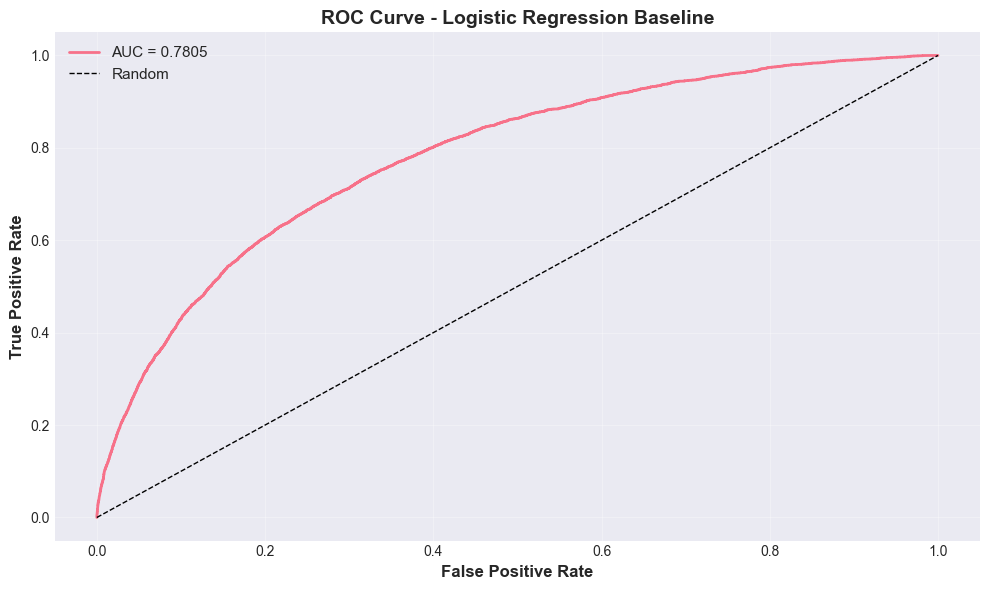

In [37]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_val)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {metrics_val["auc"]:.4f}')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - Logistic Regression Baseline', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

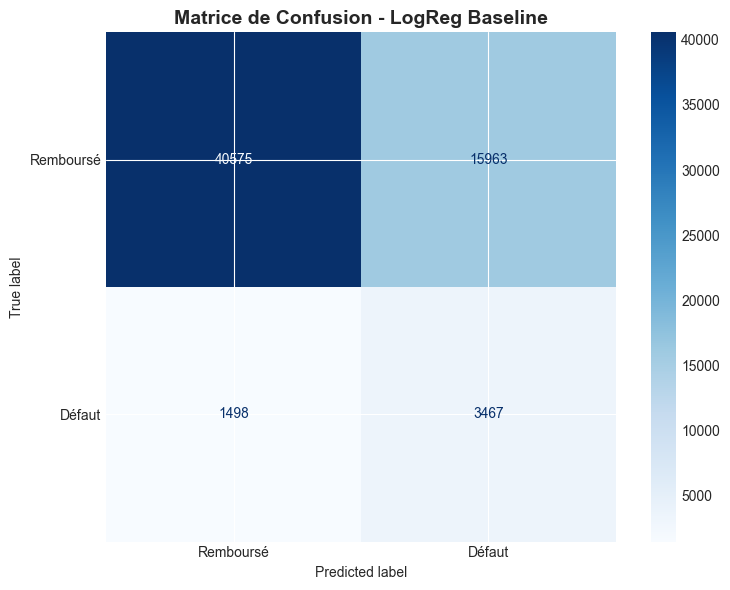

In [38]:
# Confusion Matrix
y_pred_binary = (y_pred_val >= 0.5).astype(int)

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_binary,
    display_labels=['Remboursé', 'Défaut'],
    cmap='Blues',
    ax=ax
)
plt.title('Matrice de Confusion - LogReg Baseline', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 4.3 Optimisation

In [35]:
print("="*60)
print("LOGISTIC REGRESSION - OPTIMISATION")
print("="*60)

# Espace de recherche
param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [1000, 2000]
}

logreg = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)

random_search = RandomizedSearchCV(
    logreg,
    param_distributions=param_distributions,
    n_iter=20,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

print("\nRecherche en cours...\n")
random_search.fit(X_train_scaled, y_train)

print("\n✓ Optimisation terminée!")
print(f"\nMeilleurs paramètres:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMeilleur score CV: {random_search.best_score_:.4f}")

LOGISTIC REGRESSION - OPTIMISATION

Recherche en cours...

Fitting 5 folds for each of 20 candidates, totalling 100 fits


KeyboardInterrupt: 

In [ ]:
# Évaluation du meilleur modèle
with mlflow.start_run(run_name=f"{TEAM_MEMBER}_logreg_optimized"):
    
    best_logreg = random_search.best_estimator_
    
    # Prédictions
    y_pred_train = best_logreg.predict_proba(X_train_scaled)[:, 1]
    y_pred_val = best_logreg.predict_proba(X_val_scaled)[:, 1]
    
    # Évaluation
    metrics_train = evaluate_model(y_train, y_pred_train)
    metrics_val = evaluate_model(y_val, y_pred_val)
    
    # Affichage
    print(f"\n{'Métrique':<20} {'Train':<15} {'Validation'}")
    print("-" * 60)
    print(f"{'AUC-ROC':<20} {metrics_train['auc']:<15.4f} {metrics_val['auc']:.4f}")
    print(f"{'Precision':<20} {metrics_train['precision']:<15.4f} {metrics_val['precision']:.4f}")
    print(f"{'Recall':<20} {metrics_train['recall']:<15.4f} {metrics_val['recall']:.4f}")
    print(f"{'F1-Score':<20} {metrics_train['f1']:<15.4f} {metrics_val['f1']:.4f}")
    print(f"{'Business Cost':<20} {metrics_train['business_cost']:<15.0f} {metrics_val['business_cost']:.0f}")
    
    # Log MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("model_type", "LogisticRegression_Optimized")
    
    mlflow.log_metrics({
        "train_auc": metrics_train['auc'],
        "val_auc": metrics_val['auc'],
        "val_f1": metrics_val['f1'],
        "val_business_cost": metrics_val['business_cost'],
        "cv_best_score": random_search.best_score_
    })
    
    mlflow.sklearn.log_model(best_logreg, "model")
    
    print("\n✓ Modèle optimisé loggé dans MLflow")

<div class='section-header'>
    <h2 style='margin: 0;'>5. MODÈLE 2 : LIGHTGBM</h2>
</div>

### 5.1 Baseline

In [36]:
print("="*60)
print("LIGHTGBM - BASELINE")
print("="*60)

with mlflow.start_run(run_name=f"{TEAM_MEMBER}_lgbm_baseline"):
    
    # Calculer scale_pos_weight
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    # Modèle
    lgbm_baseline = lgb.LGBMClassifier(
        objective='binary',
        metric='auc',
        scale_pos_weight=scale_pos_weight,
        n_estimators=100,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=-1
    )
    
    # Entraînement
    print(f"\nEntraînement (scale_pos_weight={scale_pos_weight:.2f})...")
    lgbm_baseline.fit(X_train, y_train)
    
    # Prédictions
    y_pred_train = lgbm_baseline.predict_proba(X_train)[:, 1]
    y_pred_val = lgbm_baseline.predict_proba(X_val)[:, 1]
    
    # Évaluation
    metrics_train = evaluate_model(y_train, y_pred_train)
    metrics_val = evaluate_model(y_val, y_pred_val)
    
    # Affichage
    print(f"\n{'Métrique':<20} {'Train':<15} {'Validation'}")
    print("-" * 60)
    print(f"{'AUC-ROC':<20} {metrics_train['auc']:<15.4f} {metrics_val['auc']:.4f}")
    print(f"{'Precision':<20} {metrics_train['precision']:<15.4f} {metrics_val['precision']:.4f}")
    print(f"{'Recall':<20} {metrics_train['recall']:<15.4f} {metrics_val['recall']:.4f}")
    print(f"{'F1-Score':<20} {metrics_train['f1']:<15.4f} {metrics_val['f1']:.4f}")
    print(f"{'Business Cost':<20} {metrics_train['business_cost']:<15.0f} {metrics_val['business_cost']:.0f}")
    
    # Log MLflow
    mlflow.log_params({
        "model_type": "LightGBM",
        "n_estimators": 100,
        "learning_rate": 0.1,
        "scale_pos_weight": scale_pos_weight
    })
    
    mlflow.log_metrics({
        "train_auc": metrics_train['auc'],
        "val_auc": metrics_val['auc'],
        "val_f1": metrics_val['f1'],
        "val_business_cost": metrics_val['business_cost']
    })
    
    mlflow.lightgbm.log_model(lgbm_baseline, "model")
    
    print("\n✓ Baseline loggée dans MLflow")

LIGHTGBM - BASELINE

Entraînement (scale_pos_weight=11.39)...


2026/01/27 08:49:59 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



Métrique             Train           Validation
------------------------------------------------------------
AUC-ROC              0.8230          0.7805
Precision            0.1933          0.1784
Recall               0.7651          0.6983
F1-Score             0.3086          0.2842
Business Cost        -623562         -157661

✓ Baseline loggée dans MLflow


### 5.2 Visualisations

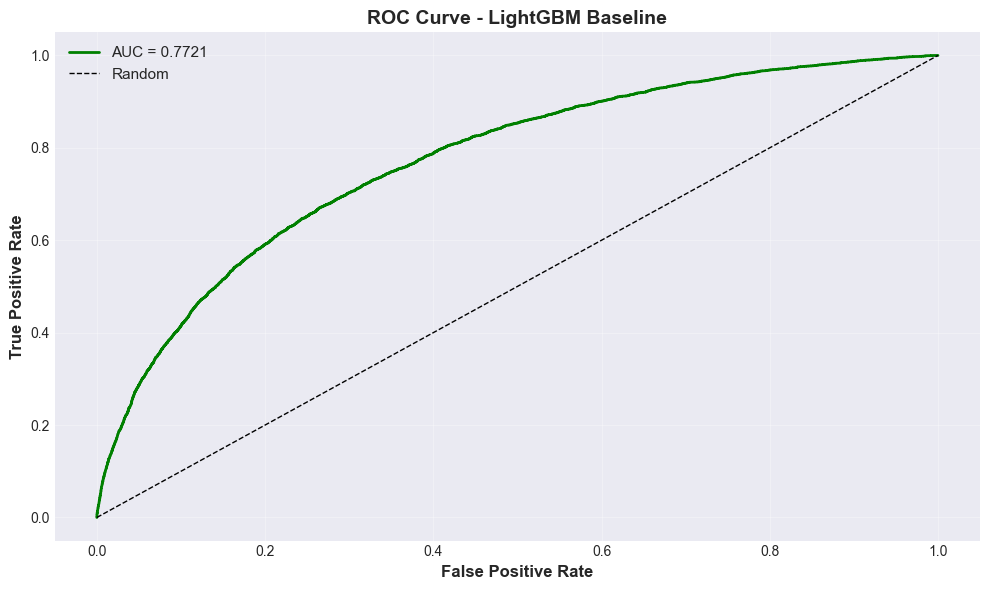

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_pred_val)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, linewidth=2, label=f'AUC = {metrics_val["auc"]:.4f}', color='green')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
plt.title('ROC Curve - LightGBM Baseline', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

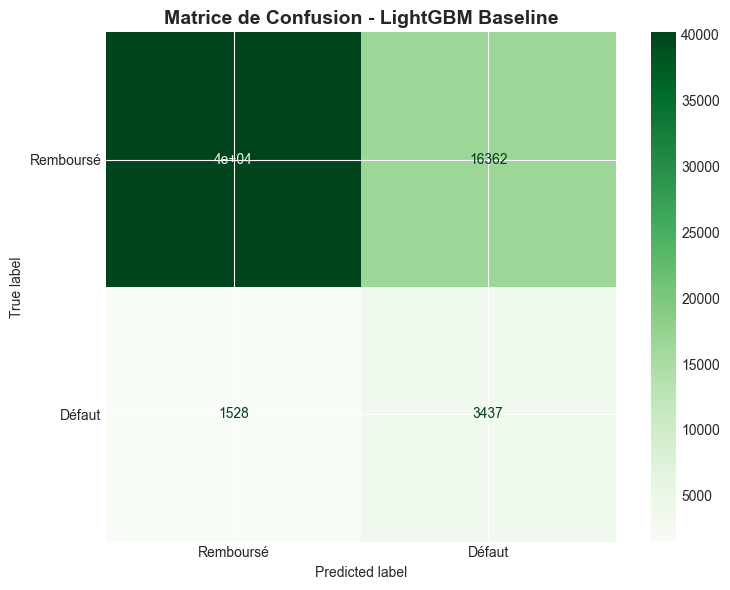

In [ ]:
# Confusion Matrix
y_pred_binary = (y_pred_val >= 0.5).astype(int)

fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_val, y_pred_binary,
    display_labels=['Remboursé', 'Défaut'],
    cmap='Greens',
    ax=ax
)
plt.title('Matrice de Confusion - LightGBM Baseline', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### 5.3 Optimisation

In [ ]:
print("="*60)
print("LIGHTGBM - OPTIMISATION")
print("="*60)

# Espace de recherche
param_distributions = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10, -1],
    'num_leaves': [15, 31, 63],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'reg_alpha': [0, 0.01, 0.1],
    'reg_lambda': [0, 0.01, 0.1]
}

lgbm = lgb.LGBMClassifier(
    objective='binary',
    metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=-1
)

random_search = RandomizedSearchCV(
    lgbm,
    param_distributions=param_distributions,
    n_iter=30,
    cv=StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=RANDOM_STATE),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=RANDOM_STATE
)

print("\nRecherche en cours (cela peut prendre du temps)...\n")
random_search.fit(X_train, y_train)

print("\n✓ Optimisation terminée!")
print(f"\nMeilleurs paramètres:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nMeilleur score CV: {random_search.best_score_:.4f}")

LIGHTGBM - OPTIMISATION

Recherche en cours (cela peut prendre du temps)...

Fitting 5 folds for each of 30 candidates, totalling 150 fits


KeyboardInterrupt: 

In [ ]:
# Évaluation du meilleur modèle
with mlflow.start_run(run_name=f"{TEAM_MEMBER}_lgbm_optimized"):
    
    best_lgbm = random_search.best_estimator_
    
    # Prédictions
    y_pred_train = best_lgbm.predict_proba(X_train)[:, 1]
    y_pred_val = best_lgbm.predict_proba(X_val)[:, 1]
    
    # Évaluation
    metrics_train = evaluate_model(y_train, y_pred_train)
    metrics_val = evaluate_model(y_val, y_pred_val)
    
    # Affichage
    print(f"\n{'Métrique':<20} {'Train':<15} {'Validation'}")
    print("-" * 60)
    print(f"{'AUC-ROC':<20} {metrics_train['auc']:<15.4f} {metrics_val['auc']:.4f}")
    print(f"{'Precision':<20} {metrics_train['precision']:<15.4f} {metrics_val['precision']:.4f}")
    print(f"{'Recall':<20} {metrics_train['recall']:<15.4f} {metrics_val['recall']:.4f}")
    print(f"{'F1-Score':<20} {metrics_train['f1']:<15.4f} {metrics_val['f1']:.4f}")
    print(f"{'Business Cost':<20} {metrics_train['business_cost']:<15.0f} {metrics_val['business_cost']:.0f}")
    
    # Log MLflow
    mlflow.log_params(random_search.best_params_)
    mlflow.log_param("model_type", "LightGBM_Optimized")
    mlflow.log_param("scale_pos_weight", scale_pos_weight)
    
    mlflow.log_metrics({
        "train_auc": metrics_train['auc'],
        "val_auc": metrics_val['auc'],
        "val_f1": metrics_val['f1'],
        "val_business_cost": metrics_val['business_cost'],
        "cv_best_score": random_search.best_score_
    })
    
    mlflow.lightgbm.log_model(best_lgbm, "model")
    
    print("\n✓ Modèle optimisé loggé dans MLflow")

### 5.4 Feature Importance

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_lgbm.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20
top_features = feature_importance.head(20)

plt.figure(figsize=(12, 8))
plt.barh(range(len(top_features)), top_features['importance'], edgecolor='black', color='forestgreen')
plt.yticks(range(len(top_features)), top_features['feature'], fontsize=10)
plt.xlabel('Importance', fontsize=12, fontweight='bold')
plt.title('Top 20 Features - LightGBM', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 features:")
print(top_features[['feature', 'importance']].head(10).to_string(index=False))

<div class='section-header'>
    <h2 style='margin: 0;'>6. COMPARAISON & SAUVEGARDE</h2>
</div>

In [ ]:
# Comparaison finale
print("="*60)
print("COMPARAISON FINALE")
print("="*60)

experiment = mlflow.get_experiment_by_name(f"credit_scoring_{TEAM_MEMBER}")
runs = mlflow.search_runs(experiment.experiment_id)

comparison = runs[[
    'tags.mlflow.runName',
    'metrics.val_auc',
    'metrics.val_f1',
    'metrics.val_business_cost'
]].sort_values('metrics.val_auc', ascending=False)

comparison.columns = ['Modèle', 'AUC', 'F1', 'Coût Métier']

print("\n" + comparison.to_string(index=False))

best_model_name = comparison.iloc[0]['Modèle']
best_auc = comparison.iloc[0]['AUC']

print(f"\n🏆 MEILLEUR: {best_model_name} (AUC={best_auc:.4f})")

In [ ]:
# Sauvegarde du meilleur modèle
MODELS_PATH = Path(f'../artifacts/models/{TEAM_MEMBER}')
MODELS_PATH.mkdir(parents=True, exist_ok=True)

# Sauvegarder
joblib.dump(best_lgbm, MODELS_PATH / 'best_model.pkl')
joblib.dump(scaler, MODELS_PATH / 'scaler.pkl')

# Métriques
import json
final_metrics = {
    'model_type': 'LightGBM_Optimized',
    'val_auc': metrics_val['auc'],
    'val_f1': metrics_val['f1'],
    'val_business_cost': metrics_val['business_cost'],
    'best_params': random_search.best_params_,
    'timestamp': datetime.now().isoformat()
}

with open(MODELS_PATH / 'best_metrics.json', 'w') as f:
    json.dump(final_metrics, f, indent=4, default=str)

print(f"✓ Sauvegardé dans {MODELS_PATH}")

<div style='background: linear-gradient(135deg, #10b981 0%, #059669 100%); padding: 30px; border-radius: 10px; margin-top: 30px;'>
    <h2 style='color: white; text-align: center; margin: 0;'>✓ MODÉLISATION PAPA TERMINÉE</h2>
    <p style='color: white; text-align: center; margin-top: 15px; font-size: 14px;'>Logistic Regression & LightGBM optimisés</p>
    <p style='color: white; text-align: center; margin-top: 10px; font-size: 12px;'>Résultats disponibles dans MLflow UI : <code>mlflow ui</code></p>
</div>